<a href="https://colab.research.google.com/github/LoniQin/deep_learning_notebooks/blob/master/tensorflow/MnistAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Packages

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Flatten, Conv2D, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler

from tensorflow.keras.datasets import mnist

## Mounting Google Drive
For convenience we mount a Google Drive so that we can read and write a from it and sync data to local computer.

In [3]:
drive_path = "/content/drive"
data_path = drive_path + "/MyDrive/data"


In [4]:
from google.colab import drive
drive.mount(drive_path)

Mounted at /content/drive


## Creating run folders

In [19]:
run_folder = os.path.join(data_path, "mnist_auto_encoder") 
if not os.path.exists(run_folder):
  os.mkdir(run_folder)

## Loading the data

Now load the mnist data.

In [5]:
(train_x, train_y), _ = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
print(train_x.shape)
print(train_y.shape)

(60000, 28, 28)
(60000,)


Filter some number to generate realistic images.

In [7]:
num = 9
filtered_images = []
filtered_numbers = []
for i in range(train_y.shape[0]):
  if train_y[i] == num:
    filtered_images.append(train_x[i, :, :])
    filtered_numbers.append(train_y[i])
filtered_images = np.array(filtered_images)
filtered_images = filtered_images.reshape((filtered_images.shape[0], filtered_images.shape[1], filtered_images.shape[2], 1))
filtered_numbers = np.array(filtered_numbers)
print(filtered_images.shape)
print(filtered_numbers.shape)

(5949, 28, 28, 1)
(5949,)


Now plot some random images:

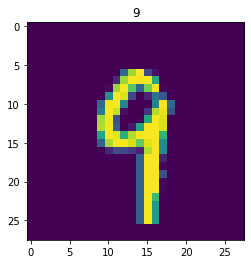

In [8]:
i = np.random.randint(0, filtered_numbers.shape[0])
plt.title(filtered_numbers[i])
plt.imshow(filtered_images[i, :, :, :].reshape(filtered_images.shape[1], filtered_images.shape[2]))

In [9]:
filtered_images = filtered_images / 255.0

## Building the AutoEncoder

1. Define common parameters.

In [10]:
input_shape = filtered_images.shape[1:]
z_dim = 2

Now build the Encoder.

In [11]:
encoder_parameters = [(32, 3, 1), (64, 3, 2),  (64, 3, 2), (64, 3, 1)]
encoder_input = Input(shape=input_shape, name='encoder_input')
x = encoder_input
for i in range(len(encoder_parameters)):
  item = encoder_parameters[i]
  conv_layer = Conv2D(filters=item[0], kernel_size=item[1], strides=item[2], padding='same', name='encoder_conv_%d'%(i))
  x = conv_layer(x)
  x = LeakyReLU()(x)
  x = BatchNormalization()(x)
  x = Dropout(0.25)(x)
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)
encoder_output = Dense(z_dim, name='encoder_output')(x)
encoder = Model(encoder_input, encoder_output)


In [12]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0     

Now build the Decoder. For convenience and elegance, make the Encoder mirror of the Encoder.

In [13]:
decoder_parameters = [(64, 3, 1), (64, 3, 2),  (32, 3, 2), (1, 3, 1)]

In [14]:
decoder_input = Input(shape=(z_dim, ), name='decoder_input')
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
for i in range(len(decoder_parameters)):
  item = decoder_parameters[i]
  conv_t_layer = Conv2DTranspose(filters=item[0], kernel_size=item[1], strides=item[2], padding='same', name='decoder_conv_t_%d'%(i))
  x = conv_t_layer(x)
  if i < len(decoder_parameters) - 1:
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
  else:
    x = Activation('sigmoid')(x)
decoder_output = x
decoder = Model(decoder_input, decoder_output)

In [15]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 64)          0   

Now join the Encoder to the Decoder so that we can train the encoder and decoder simutaneously.

In [16]:
model_input = encoder_input
model_output = decoder(encoder_output)
model = Model(model_input, model_output)

This is the overall archetecture of AutoEncoder.

In [17]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0   

## Defining Callbacks
Define a ModelCheckpoint to save weights for further usage.

In [23]:
checkpoint = ModelCheckpoint(os.path.join(run_folder, 'weights.h5'), save_weights_only = True, verbose=1)

Define a Learning Rate Scheduler to fine tune learning rate over time.

In [24]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * 0.5
schedular = LearningRateScheduler(scheduler)

Define a costom Callback to save latest images.

In [31]:
class SaveImageCallback(Callback):
    
    def __init__(self, run_folder, print_every_n_batches, initial_epoch, decoder, z_dim):
        self.current_epoch = initial_epoch
        self.run_folder = run_folder
        self.decoder = decoder
        self.print_every_n_batches = print_every_n_batches
        self.z_dim = z_dim

    def on_batch_end(self, batch, logs={}):  
        if batch % self.print_every_n_batches == 0:
            z_new = np.random.normal(size = (1,self.z_dim))
            reconst = self.decoder.predict(np.array(z_new))[0].squeeze()
            filepath = os.path.join(self.run_folder, 'img_' + str(self.current_epoch).zfill(3) + '_' + str(batch) + '.jpg')
            if len(reconst.shape) == 2:
                plt.imsave(filepath, reconst, cmap='gray_r')
            else:
                plt.imsave(filepath, reconst)

    def on_epoch_begin(self, epoch, logs={}):
        self.current_epoch += 1

In [32]:
save_image_callback = SaveImageCallback(run_folder=run_folder, print_every_n_batches=100, initial_epoch=0, decoder=decoder, z_dim=z_dim)

## Compiling the model

In [33]:
batch_size = 64
learning_rate = 0.001
epochs = 1

In [34]:
optimizer = Adam(learning_rate)
def r_loss(y_true, y_pred):
  return K.mean(K.square(y_true - y_pred), axis=[1, 2, 3])
model.compile(optimizer=optimizer, loss=r_loss)

## Loading weights if needed

In [35]:
weights_path = os.path.join(run_folder, "weights.h5")
if os.path.exists(weights_path):
  model.load_weights(weights_path)

## Training the model

In [37]:
model.fit(x=filtered_images, y=filtered_images, batch_size=batch_size, epochs=100, shuffle=True, callbacks=[checkpoint, schedular, save_image_callback])

Epoch 1/1001
93/93 [==============================] - 1s 9ms/step - loss: 0.0324

Epoch 00001: saving model to /content/drive/MyDrive/data/mnist_auto_encoder/weights.h5
Epoch 2/1001
93/93 [==============================] - 1s 9ms/step - loss: 0.0324

Epoch 00002: saving model to /content/drive/MyDrive/data/mnist_auto_encoder/weights.h5
Epoch 3/1001
93/93 [==============================] - 1s 8ms/step - loss: 0.0325

Epoch 00003: saving model to /content/drive/MyDrive/data/mnist_auto_encoder/weights.h5
Epoch 4/1001
93/93 [==============================] - 1s 8ms/step - loss: 0.0323

Epoch 00004: saving model to /content/drive/MyDrive/data/mnist_auto_encoder/weights.h5
Epoch 5/1001
93/93 [==============================] - 1s 8ms/step - loss: 0.0323

Epoch 00005: saving model to /content/drive/MyDrive/data/mnist_auto_encoder/weights.h5
Epoch 6/1001
93/93 [==============================] - 1s 9ms/step - loss: 0.0323

Epoch 00006: saving model to /content/drive/MyDrive/data/mnist_auto_encod

## Generate random images

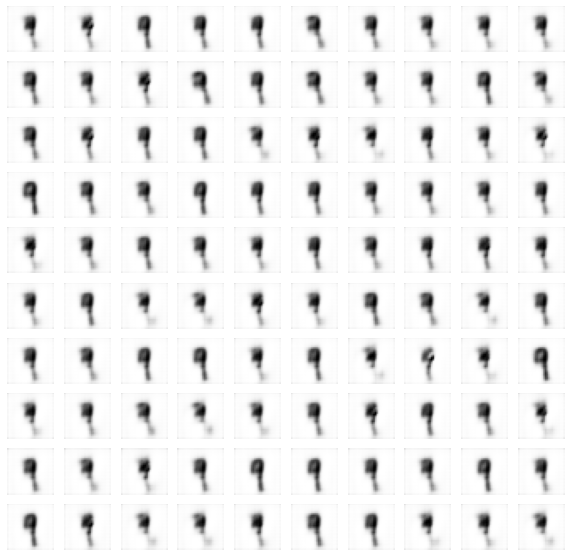

In [39]:
row_count, column_count = 10, 10
noise = np.random.normal(size = (row_count * column_count,z_dim))
gen_imgs = decoder.predict(noise) * 255.0
fig, axs = plt.subplots(row_count, column_count, figsize=(10,10))
for i in range(row_count):
    for j in range(column_count):
        axs[i,j].imshow(np.squeeze(gen_imgs[i * row_count + j, :,:,:]), cmap = 'gray_r')
        axs[i,j].axis('off')
plt.show()